# Carpet Claim Data Analysis
Investigate the defects in the delamination testing data using one monthe data (Aug 2017) at various intervals

In [1]:
# Load necessary libraries
import numpy as np
import pandas as pd
import os, inspect
import csv
%matplotlib inline 
import pylab
import matplotlib.pylab as plt
import matplotlib.image as img
import scipy.stats as stats
import seaborn as sns
from IPython.core.display import HTML 
from sklearn.preprocessing import scale
from bokeh.io import show, output_file
from bokeh.plotting import figure
#from bokeh.charts import Bar, BoxPlot
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define functions

In [2]:
#define a function to visualize results
def _plot_value_series(self, dt, factor, yName, iplot, varDefect=None):
    #self is data array
    nrow = len(self)
    #Feature
    self_max = np.max(self)
    self_min = np.min(self)
    self_mu = np.mean(self)
    self_std = np.std(self)
    upper_limit = self_mu + factor * self_std;
    lower_limit = self_mu - factor * self_std;
    
    #create a vector
    ts = range(nrow)
 
    #check timepoints
    len_time = len(dt)
    if len_time > nrow or len_time < nrow:
        dt = ts
        
    fig = plt.figure(figsize=(11,4))    
    ax = plt.subplot(111)  
    
     #plt.plot(dt,X,'k-')
    s1 = np.random.rand(*dt.shape) * 80 + 50
    plt.scatter(dt,self, s1, c="k", alpha = 0.8)  
    #plt.plot(dt,self,'k-')
    
    #####horizontal line
    upper_limit_data = np.array([upper_limit for i in range(len(dt))])
    plt.plot(dt, upper_limit_data, 'r--', label='Upper Limit') 

    lower_limit_data = np.array([lower_limit for i in range(len(dt))])
    plt.plot(dt, lower_limit_data, 'g--', label='Lower Limit') 
    
    #ax.axhline(y=upper_limit, xmin=dt[0], xmax = dt[len(dt)-1],color = 'b', label='Upper limit')
    #ax.axhline(y=lower_limit, xmin=dt[0], xmax = dt[len(dt)-1],color='g', label='Lower limit')
    plt.ylabel(yName)
    plt.xlabel('Time')
    
    # retrieving the indices where "sng > max" using np.where    
    upperIndex = []
    upperCnt = 0.0
    lowerIndex = []
    lowerCnt = 0.0
    for index, item in enumerate(self):        
        if item > upper_limit:
            upperCnt += 1.0
            upperIndex.append(index)
            plt.plot(dt[index],item, 'bs') 
        else:
            if item < lower_limit:
                lowerCnt += 1.0
                lowerIndex.append(index)
                plt.plot(dt[index],item, 'ms')           
            
        if varDefect is not None and varDefect[index] > 0:
            s = np.pi * varDefect[index]**2 #np.random.rand(*dt.shape) * 80 + 50
            plt.scatter(dt[index],item,s, c="r", alpha = 0.5)         
            
    # Now add the legend with some customizations.
    legend = ax.legend(loc='best', shadow=True)

    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')

    # Set the fontsize
    for label in legend.get_texts():
        label.set_fontsize('large')

    for label in legend.get_lines():
        label.set_linewidth(1.0)  # the legend line width
    
    plt.show()
    
    # display the failure data points
    if (iplot == 1) and (upperCnt > 0.0):
        print('Number of above upper limit points = ', upperCnt)
        print('Above upperlimit points:', upperIndex)        
    
    if (iplot == 1) and (lowerCnt > 0.0):
        print('Number of below lowerlimit points = ', lowerCnt)
        print('Below lowerlimit points:', lowerIndex)    

In [3]:
#Visualizing Interrelationships between Attributes - scatter
def _plot_multivariate(self):
    plt.figure(figsize=(14,14))
    pd.plotting.scatter_matrix(self, diagonal="kde") 
    plt.tight_layout()
    plt.show()

In [4]:
#Visualizing Attribute and Label Correlations Using a Heat Map
#calculate correlations between real-valued attributes
def _plot_heatmap(self):
    xcorMat = pd.DataFrame(self.corr())
    #visualize correlations using heatmap
    plt.pcolor(xcorMat)
    plt.show() 

In [5]:
# plot quantile-quantile of data   
def _plot_QQ(self):    
    #plot quantile-quantile of a timeseries
    stats.probplot(self, dist="norm", plot=plt)
    plt.show() 

In [6]:
def _plot_boxplot(self):
    #plot box plot of one variable or matrix
    plt.figure(figsize=(11,11)) 
    plt.boxplot(self, 0, 'rD', 0, 0.75)    
    plt.show()

In [7]:
def _timeseries_plot(self):
    #plot time series of univaraite or multivariable
    plt.figure(figsize=(15,4))
    ax = self.plot()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show()
    plt.show()

In [8]:
# clean latex type
def _read_tagData(dataModel, tag, thred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] == thred, :]
    #print(dataModel.loc[:,['GFROLL', 'GFLTYP','delamIndex', 'delamMin']], len(dataModel_output.GFROLL))
    return dataModel_output

In [9]:
def _read_upper(dataModel, tag, upperThred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] <= upperThred,:]
    return dataModel_output
        
def _read_lower(dataModel, tag, lowerThred):    
    dataModel_output = dataModel.loc[lambda dataModel: dataModel[tag] >= lowerThred,:]
    return dataModel_output

def _drop_rows(dataModel, tag, thred):
    #drop other GFTYPE
    # thred can be a numerical or string   
    
    dataModel_rem = dataModel[dataModel[tag] != thred]
    return dataModel_rem

In [10]:
from collections import Counter
def class_info(classes):
    counts = Counter(classes)
    total = sum(list(counts.values()))
  
    for cls in counts.keys():
        print("%6s: % 7d  =  % 5.1f%%" % (cls, counts[cls], counts[cls]/total*100))


In [11]:
 def _create_filename(path, fname, affix = '.csv'):
        # create new file name
                    
        output_name = fname + affix        
        foutput_name = os.path.join(path, '', output_name)
              
        return foutput_name

In [12]:
# set working directory
#curPath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory
#parentDir = os.path.split(curPath)[0];
parentDir = 'C:/Users/E154709/Desktop/Mohawk/Claims'
os.chdir(parentDir)

outputPath = parentDir + '/Output/'
if not os.path.exists(outputPath):
    os.mkdir(outputPath)
    
codePath = parentDir + '/Code/'
if not os.path.exists(codePath):
    os.mkdir(codePath)
    
dataPath = parentDir + '/Data/'
if not os.path.exists(dataPath):
    os.mkdir(dataPath)


In [101]:
#create data file
    
fname = 'rawData_con'
frawData = _create_filename(dataPath,fname)
print(frawData)

fname = 'modelData'
fmodelData = _create_filename(dataPath,fname)
print(fmodelData)

C:/Users/E154709/Desktop/Mohawk/Claims/Data/rawData_con.csv
C:/Users/E154709/Desktop/Mohawk/Claims/Data/modelData.csv


# Import and Consolidate Claim Data 

Run this section only if you have not consolidated the raw data. Otherwise, directly go to the section of claim data processing

In [102]:
# Read Claims Data
import chardet
    
Claim_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims.csv'
ClaimsData = pd.read_csv(Claim_dataPath, encoding='latin1')  # Read the claims data

ClaimReason_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Reason.csv'
ClaimReason = pd.read_csv(ClaimReason_dataPath, encoding='utf-8')  # Read the claimReason data

ClaimStatus_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Status.csv'
ClaimStatus = pd.read_csv(ClaimStatus_dataPath, encoding='utf-8')  # Read the claimReason data

ClaimType_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/Claims_Type.csv'
ClaimType = pd.read_csv(ClaimType_dataPath, encoding='utf-8')  # Read the claimReason data

ClaimCustomer_dataPath = 'C:/Users/E154709/Desktop/Mohawk/Claims/Data/SLS_Customer.csv'
ClaimCustomer = pd.read_csv(ClaimCustomer_dataPath, encoding='latin1')  # Read the claimReason data

In [15]:
#check the claim data
print(ClaimsData.describe())
print(ClaimsData.shape)
print(ClaimsData.columns.values)

       FACT_CUSTOMER_CLAIMS_PK  DIM_DIVISION_CUSTOMER_PK  \
count             3.114910e+05              3.114910e+05   
mean              1.238682e+07              2.042229e+06   
std               7.553653e+05              2.644398e+05   
min               1.747000e+03              1.257705e+06   
25%               1.235823e+07              1.984710e+06   
50%               1.244263e+07              2.155343e+06   
75%               1.252643e+07              2.212648e+06   
max               1.261002e+07              2.318022e+06   

       DIM_DIVISION_CUSTOMER_GK  CLAIM_DATE_PK  CLAIM_STATUS_DATE_PK  \
count             311491.000000   3.114910e+05          3.114910e+05   
mean              282254.679564   2.017000e+07          2.017061e+07   
std                69499.110024   3.625091e+04          3.353591e+02   
min                54987.000000  -1.000000e+00          2.010052e+07   
25%               242550.000000   2.017030e+07          2.017040e+07   
50%               268953.00

In [103]:
#check the claim data
print(ClaimReason.describe())
print(ClaimReason.shape)
print(ClaimReason.columns.values)

       DIM_CLAIM_REASON_PK  DIM_CLAIM_REASON_GK
count             566.0000           566.000000
mean              280.5000           281.496466
std               163.5344           163.540515
min                -2.0000            -2.000000
25%               139.2500           140.250000
50%               280.5000           281.500000
75%               421.7500           422.750000
max               563.0000           564.000000
(566, 13)
['DIM_CLAIM_REASON_PK' 'DIM_CLAIM_REASON_GK' 'CLAIM_REASON_CD'
 'CLAIM_REASON_DESC' 'CLAIM_REASON_SHORT_DESC' 'CLAIM_DEPARTMENT_CD'
 'QUALITY_RELATED_CD' 'ENTERPRISE_ENTITY_CD' 'SOURCE_SYSTEM_CD'
 'DELETE_IND' 'CREATE_DTM' 'UPDATE_DTM' 'LANDING_DTM']


In [104]:
ClaimReason=ClaimReason.set_index('DIM_CLAIM_REASON_PK')
print(ClaimReason.head(2))

                     DIM_CLAIM_REASON_GK       CLAIM_REASON_CD  \
DIM_CLAIM_REASON_PK                                              
 64                                   65                   463   
-2                                    -2  Not Applicable (N/A)   

                         CLAIM_REASON_DESC CLAIM_REASON_SHORT_DESC  \
DIM_CLAIM_REASON_PK                                                  
 64                  CUT SHORTAGE - POLICY                CUTPOLCY   
-2                    Not Applicable (N/A)    Not Applicable (N/A)   

                      CLAIM_DEPARTMENT_CD    QUALITY_RELATED_CD  \
DIM_CLAIM_REASON_PK                                               
 64                                   NaN                     N   
-2                   Not Applicable (N/A)  Not Applicable (N/A)   

                     ENTERPRISE_ENTITY_CD      SOURCE_SYSTEM_CD DELETE_IND  \
DIM_CLAIM_REASON_PK                                                          
 64                          

In [105]:
ClaimsData=ClaimsData.set_index('DIM_CLAIM_REASON_PK')
print(ClaimsData.head(2))

                     FACT_CUSTOMER_CLAIMS_PK TRX_CUSTOMER_CLAIMS_ID  \
DIM_CLAIM_REASON_PK                                                   
492                                 12375985            R-7009810-1   
101                                 12404445            R-7020309-1   

                     DIM_DIVISION_CUSTOMER_PK  DIM_DIVISION_CUSTOMER_GK  \
DIM_CLAIM_REASON_PK                                                       
492                                   1843099                    270298   
101                                   1977635                    286706   

                     CLAIM_DATE_PK  CLAIM_STATUS_DATE_PK  CLAIM_ENTRY_DATE_PK  \
DIM_CLAIM_REASON_PK                                                             
492                       20170330              20170330             20170330   
101                       20170426              20170426             20170426   

                     INVOICE_DATE_PK  CREDIT_MEMO_DATE_PK  DEBIT_MEMO_DATE_PK  \
DIM_CLAI

In [106]:
#Claims_Reason = ClaimsData.join(ClaimReason, rsuffix = '_reason')
Claims_Reason = pd.concat([ClaimsData, ClaimReason], axis=1, join_axes = [ClaimsData.index])
print(Claims_Reason.head(2), Claims_Reason.shape)

                     FACT_CUSTOMER_CLAIMS_PK TRX_CUSTOMER_CLAIMS_ID  \
DIM_CLAIM_REASON_PK                                                   
492                                 12375985            R-7009810-1   
101                                 12404445            R-7020309-1   

                     DIM_DIVISION_CUSTOMER_PK  DIM_DIVISION_CUSTOMER_GK  \
DIM_CLAIM_REASON_PK                                                       
492                                   1843099                    270298   
101                                   1977635                    286706   

                     CLAIM_DATE_PK  CLAIM_STATUS_DATE_PK  CLAIM_ENTRY_DATE_PK  \
DIM_CLAIM_REASON_PK                                                             
492                       20170330              20170330             20170330   
101                       20170426              20170426             20170426   

                     INVOICE_DATE_PK  CREDIT_MEMO_DATE_PK  DEBIT_MEMO_DATE_PK  \
DIM_CLAI

In [107]:
Claims_Reason.reset_index(inplace=True)
print(Claims_Reason.head(2))

   DIM_CLAIM_REASON_PK  FACT_CUSTOMER_CLAIMS_PK TRX_CUSTOMER_CLAIMS_ID  \
0                  492                 12375985            R-7009810-1   
1                  101                 12404445            R-7020309-1   

   DIM_DIVISION_CUSTOMER_PK  DIM_DIVISION_CUSTOMER_GK  CLAIM_DATE_PK  \
0                   1843099                    270298       20170330   
1                   1977635                    286706       20170426   

   CLAIM_STATUS_DATE_PK  CLAIM_ENTRY_DATE_PK  INVOICE_DATE_PK  \
0              20170330             20170330         20170330   
1              20170426             20170426         20170426   

   CREDIT_MEMO_DATE_PK       ...               CLAIM_REASON_DESC  \
0             20170330       ...         LTD DIST VOLUME REBATES   
1             20170426       ...                           OTHER   

   CLAIM_REASON_SHORT_DESC  CLAIM_DEPARTMENT_CD  QUALITY_RELATED_CD  \
0                 LTDVOLRB                  NaN                   N   
1                

In [108]:
ClaimStatus=ClaimStatus.set_index('DIM_CLAIM_STATUS_PK')
Claims_Reason = Claims_Reason.set_index('DIM_CLAIM_STATUS_PK')
Claims_Status = pd.concat([Claims_Reason, ClaimStatus], axis=1, join_axes = [Claims_Reason.index])
print(Claims_Status.head(2), Claims_Status.shape)

                     DIM_CLAIM_REASON_PK  FACT_CUSTOMER_CLAIMS_PK  \
DIM_CLAIM_STATUS_PK                                                 
37                                   492                 12375985   
37                                   101                 12404445   

                    TRX_CUSTOMER_CLAIMS_ID  DIM_DIVISION_CUSTOMER_PK  \
DIM_CLAIM_STATUS_PK                                                    
37                             R-7009810-1                   1843099   
37                             R-7020309-1                   1977635   

                     DIM_DIVISION_CUSTOMER_GK  CLAIM_DATE_PK  \
DIM_CLAIM_STATUS_PK                                            
37                                     270298       20170330   
37                                     286706       20170426   

                     CLAIM_STATUS_DATE_PK  CLAIM_ENTRY_DATE_PK  \
DIM_CLAIM_STATUS_PK                                              
37                               20170330    

In [109]:
#Claims_Status = Claims_Reason.join(ClaimStatus, rsuffix = '_status')
Claims_Status.reset_index(inplace=True)
print(Claims_Status.shape)

(311491, 69)


In [110]:
ClaimType=ClaimType.set_index('DIM_CLAIM_TYPE_PK')
Claims_Status = Claims_Status.set_index('DIM_CLAIM_TYPE_PK')
Claims_Type = pd.concat([Claims_Status, ClaimType], axis=1, join_axes = [Claims_Status.index])
print(Claims_Type.head(2), Claims_Type.shape)

                   DIM_CLAIM_STATUS_PK  DIM_CLAIM_REASON_PK  \
DIM_CLAIM_TYPE_PK                                             
10                                  37                  492   
8                                   37                  101   

                   FACT_CUSTOMER_CLAIMS_PK TRX_CUSTOMER_CLAIMS_ID  \
DIM_CLAIM_TYPE_PK                                                   
10                                12375985            R-7009810-1   
8                                 12404445            R-7020309-1   

                   DIM_DIVISION_CUSTOMER_PK  DIM_DIVISION_CUSTOMER_GK  \
DIM_CLAIM_TYPE_PK                                                       
10                                  1843099                    270298   
8                                   1977635                    286706   

                   CLAIM_DATE_PK  CLAIM_STATUS_DATE_PK  CLAIM_ENTRY_DATE_PK  \
DIM_CLAIM_TYPE_PK                                                             
10                 

In [111]:
#Claims_Type = Claims_Status.join(ClaimType, rsuffix = '_type')
Claims_Type.reset_index(inplace=True)
print(Claims_Type.shape)

(311491, 83)


In [112]:
#ClaimCustomer = ClaimCustomer.rename(columns = {'SOLD_TO_CUSTOMER_GK':'PRIMARY_CUSTOMER_GK', 'SOLD_TO_CUSTOMER_PK':'PRIMARY_CUSTOMER_PK'})
ClaimCustomer = ClaimCustomer.rename(columns = {'SOLD_TO_CUSTOMER_GK':'PRIMARY_CUSTOMER_GK'})
tagList = list(ClaimCustomer.head(1).columns.values)
print(tagList)

['FISCAL_YR_NUM', 'FISCAL_MONTH_NUM', 'SOLD_TO_CUSTOMER_PK', 'PRIMARY_CUSTOMER_GK', 'CUSTOMER_NUM', 'CUSTOMER_SUFFIX_NUM', 'CUSTOMER_NAME', 'DIVISION_CD', 'SLS']


In [113]:
print(ClaimCustomer.shape)

(235505, 9)


In [114]:
ClaimCustomer=ClaimCustomer.set_index('PRIMARY_CUSTOMER_GK')
Claims_Type = Claims_Type.set_index('PRIMARY_CUSTOMER_GK')

# Customer data cleaning and group

In [115]:
claimCustomer_na = ClaimCustomer.dropna(axis=0, how = 'any')
print(claimCustomer_na.shape, claimCustomer_na.head(2))

(205765, 8)                      FISCAL_YR_NUM  FISCAL_MONTH_NUM  SOLD_TO_CUSTOMER_PK  \
PRIMARY_CUSTOMER_GK                                                         
230524                        2017                 2              1352468   
379277                        2017                 3              2114829   

                     CUSTOMER_NUM  CUSTOMER_SUFFIX_NUM  \
PRIMARY_CUSTOMER_GK                                      
230524                     100668                 1832   
379277                     406721                    0   

                                      CUSTOMER_NAME DIVISION_CD        SLS  
PRIMARY_CUSTOMER_GK                                                         
230524               LOWES OF OSAGE BEACH     #1147           R    9573.83  
379277                        WEITZ SUPLY CHAIN LLC           C  100700.24  


In [116]:
customerData = claimCustomer_na
customerData.reset_index(inplace=True)

In [117]:
customerName = customerData.groupby(['CUSTOMER_NAME', 'PRIMARY_CUSTOMER_GK']).sum()
customerName.reset_index(inplace=True)
customerName = customerName.set_index('PRIMARY_CUSTOMER_GK')
print(customerName.shape,customerName.head(2))

(35271, 7)                       CUSTOMER_NAME  FISCAL_YR_NUM  FISCAL_MONTH_NUM  \
PRIMARY_CUSTOMER_GK                                                    
408823               067 / STERLING           4034                15   
320643                072366 BC LTD          12102                39   

                     SOLD_TO_CUSTOMER_PK  CUSTOMER_NUM  CUSTOMER_SUFFIX_NUM  \
PRIMARY_CUSTOMER_GK                                                           
408823                           4535826        830570                    0   
320643                          12437032       1353966                    0   

                          SLS  
PRIMARY_CUSTOMER_GK            
408823                 533.46  
320643               16411.23  


In [54]:
saleDollar = customerData.groupby(['PRIMARY_CUSTOMER_GK']).sum()
print(saleDollar.head(20), saleDollar.shape)

                     FISCAL_YR_NUM  FISCAL_MONTH_NUM  SOLD_TO_CUSTOMER_PK  \
PRIMARY_CUSTOMER_GK                                                         
54991                        12102                37             13357297   
54992                         2017                 4              2201280   
54995                         8068                24              8834412   
55004                         2017                 7              2268861   
55013                         2017                 6              2102177   
55033                         2017                10              2102182   
55034                         2017                 6              2191472   
55082                         2017                 4              2074718   
55105                         6051                11              6584072   
55115                         2017                 3              2211072   
55116                        20170                55             21947200   

In [118]:
saleNumber = customerData.pivot_table(index='PRIMARY_CUSTOMER_GK', values='SLS', aggfunc=len)
saleNumber = saleNumber.rename(columns={"SLS": "numSales"})
print(saleNumber.head(20), saleNumber.shape)

                     numSales
PRIMARY_CUSTOMER_GK          
54991                     6.0
54992                     1.0
54995                     4.0
55004                     1.0
55013                     1.0
55033                     1.0
55034                     1.0
55082                     1.0
55105                     3.0
55115                     1.0
55116                    10.0
55121                    10.0
55139                     2.0
55146                     3.0
55164                     1.0
55213                     8.0
55217                     2.0
55252                     3.0
55259                     5.0
55266                     4.0 (35271, 1)


In [119]:
saleDollar2 = customerData.pivot_table(index='PRIMARY_CUSTOMER_GK', values='SLS', aggfunc=sum)
saleDollar = saleDollar2.rename(columns={"SLS": "dollarSales"})
print(saleDollar.head(20), saleDollar.shape)

                     dollarSales
PRIMARY_CUSTOMER_GK             
54991                   28080.44
54992                     264.98
54995                   25622.77
55004                    4273.93
55013                     171.48
55033                     313.10
55034                     374.85
55082                     596.76
55105                    6604.34
55115                    8742.65
55116                  241296.53
55121                  112419.43
55139                   10622.43
55146                   27276.88
55164                    3395.72
55213                   42637.88
55217                   37360.88
55252                   22158.83
55259                    5765.52
55266                  115340.13 (35271, 1)


In [120]:
customerSale = pd.concat([saleNumber, saleDollar], axis=1)
print(customerSale.head(2), customerSale.shape)

                     numSales  dollarSales
PRIMARY_CUSTOMER_GK                       
54991                     6.0     28080.44
54992                     1.0       264.98 (35271, 2)


# Claim Data Cleaning and Group

In [121]:
print(Claims_Type.head(2), Claims_Type.shape)

                     DIM_CLAIM_TYPE_PK  DIM_CLAIM_STATUS_PK  \
PRIMARY_CUSTOMER_GK                                           
270298                              10                   37   
286705                               8                   37   

                     DIM_CLAIM_REASON_PK  FACT_CUSTOMER_CLAIMS_PK  \
PRIMARY_CUSTOMER_GK                                                 
270298                               492                 12375985   
286705                               101                 12404445   

                    TRX_CUSTOMER_CLAIMS_ID  DIM_DIVISION_CUSTOMER_PK  \
PRIMARY_CUSTOMER_GK                                                    
270298                         R-7009810-1                   1843099   
286705                         R-7020309-1                   1977635   

                     DIM_DIVISION_CUSTOMER_GK  CLAIM_DATE_PK  \
PRIMARY_CUSTOMER_GK                                            
270298                                 270298       2

In [122]:
type_unique = set(Claims_Type.CLAIM_STATUS_TYPE_CD)
uniqueCnt = len(type_unique)
print(uniqueCnt, type_unique) 

52 {'32', '17', '73', '28', '30', '45', '47', '23', '35', '53', 'Unknown', '49', '3', '29', '80', '36', '31', '50', '18', '13', '38', '19', '46', '22', '51', '11', '93', '43', '52', '21', '97', '54', '10', '9', '90', '6', '14', '44', '75', '83', '4', '12', '33', '81', '16', '63', '8', '89', '20', '48', '7', '15'}


In [123]:
quality_unique = set(Claims_Type.QUALITY_RELATED_CD)
uniqueCnt = len(quality_unique)
print(uniqueCnt, quality_unique) 

4 {'V', 'Unknown', 'Y', 'N'}


In [163]:
def class_info(classes):
    counts = Counter(classes)
    total = sum(list(counts.values()))
    
    cper = []
    for cls in counts.keys():
        print("%6s: % 7d  =  % 5.1f%%" % (cls, counts[cls], counts[cls]/total*100))
        cper.append(counts[cls]/total)
    
    return counts, cper

In [164]:
ctype = Claims_Type.QUALITY_RELATED_CD
qcount, qper = class_info(ctype)
print(qcount, qper)

     N:  190705  =   61.2%
     Y:   97446  =   31.3%
Unknown:   17599  =    5.6%
     V:    5741  =    1.8%
Counter({'N': 190705, 'Y': 97446, 'Unknown': 17599, 'V': 5741}) [0.6122327771909943, 0.3128372890388486, 0.056499224696700705, 0.018430709073456376]


[190705, 97446, 17599, 5741]


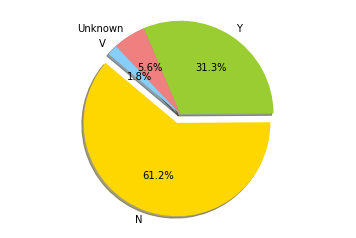

In [165]:
# Data to plot
labels = list(qcounts.keys())
sizes = list(qcounts.values())
print(sizes)
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
explode = (0.1, 0, 0, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [143]:
# kee
tag = 'QUALITY_RELATED_CD'
thred = 'Y'
Claims_Quality = Claims_Type.loc[lambda Claims_Type: Claims_Type[tag] == thred, :]
print(Claims_Quality.shape, Claims_Quality.head(2))

(97446, 82)                      DIM_CLAIM_TYPE_PK  DIM_CLAIM_STATUS_PK  \
PRIMARY_CUSTOMER_GK                                           
252233                               1                   22   
252029                              38                   22   

                     DIM_CLAIM_REASON_PK  FACT_CUSTOMER_CLAIMS_PK  \
PRIMARY_CUSTOMER_GK                                                 
252233                                70                 12583533   
252029                               371                 12290438   

                    TRX_CUSTOMER_CLAIMS_ID  DIM_DIVISION_CUSTOMER_PK  \
PRIMARY_CUSTOMER_GK                                                    
252233                         R-7089121-1                   1371696   
252029                         R-6973589-2                   2128664   

                     DIM_DIVISION_CUSTOMER_GK  CLAIM_DATE_PK  \
PRIMARY_CUSTOMER_GK                                            
252233                                 25

In [144]:
class_info(Claims_Quality.CLAIM_STATUS_TYPE_CD)

    30:   24929  =   25.6%
    50:   56337  =   57.8%
    80:    1214  =    1.2%
    97:    1872  =    1.9%
    45:     792  =    0.8%
    17:     238  =    0.2%
    22:     399  =    0.4%
     6:     644  =    0.7%
    48:     558  =    0.6%
    15:     534  =    0.5%
    33:     207  =    0.2%
    51:    6253  =    6.4%
    21:     153  =    0.2%
    14:     446  =    0.5%
    31:      67  =    0.1%
    12:      61  =    0.1%
    49:     130  =    0.1%
     8:     250  =    0.3%
    18:      69  =    0.1%
    89:     165  =    0.2%
    16:     163  =    0.2%
    46:      69  =    0.1%
    81:      21  =    0.0%
    93:      26  =    0.0%
    10:     123  =    0.1%
    32:      60  =    0.1%
    47:      48  =    0.0%
    52:      33  =    0.0%
    36:     732  =    0.8%
    28:      24  =    0.0%
    19:     117  =    0.1%
    35:     104  =    0.1%
    13:      20  =    0.0%
    38:      33  =    0.0%
     9:       2  =    0.0%
    73:      28  =    0.0%
    83:      16  =    0.0%
 

Counter({'10': 123,
         '11': 9,
         '12': 61,
         '13': 20,
         '14': 446,
         '15': 534,
         '16': 163,
         '17': 238,
         '18': 69,
         '19': 117,
         '20': 423,
         '21': 153,
         '22': 399,
         '23': 19,
         '28': 24,
         '30': 24929,
         '31': 67,
         '32': 60,
         '33': 207,
         '35': 104,
         '36': 732,
         '38': 33,
         '4': 6,
         '45': 792,
         '46': 69,
         '47': 48,
         '48': 558,
         '49': 130,
         '50': 56337,
         '51': 6253,
         '52': 33,
         '53': 1,
         '54': 1,
         '6': 644,
         '63': 47,
         '7': 2,
         '73': 28,
         '8': 250,
         '80': 1214,
         '81': 21,
         '83': 16,
         '89': 165,
         '9': 2,
         '90': 1,
         '93': 26,
         '97': 1872})

In [145]:
# Paid = 1
Claims_Quality['CLAIM_STATUS_TYPE_CD'] = Claims_Quality['CLAIM_STATUS_TYPE_CD'].replace(['48', '49', '50','51'], '1')
# Declined = 0
Claims_Quality['CLAIM_STATUS_TYPE_CD'] = Claims_Quality['CLAIM_STATUS_TYPE_CD'].replace(['30', '35', '36'], '0')
class_info(Claims_Quality.CLAIM_STATUS_TYPE_CD)

     0:   25765  =   26.4%
     1:   63278  =   64.9%
    80:    1214  =    1.2%
    97:    1872  =    1.9%
    45:     792  =    0.8%
    17:     238  =    0.2%
    22:     399  =    0.4%
     6:     644  =    0.7%
    15:     534  =    0.5%
    33:     207  =    0.2%
    21:     153  =    0.2%
    14:     446  =    0.5%
    31:      67  =    0.1%
    12:      61  =    0.1%
     8:     250  =    0.3%
    18:      69  =    0.1%
    89:     165  =    0.2%
    16:     163  =    0.2%
    46:      69  =    0.1%
    81:      21  =    0.0%
    93:      26  =    0.0%
    10:     123  =    0.1%
    32:      60  =    0.1%
    47:      48  =    0.0%
    52:      33  =    0.0%
    28:      24  =    0.0%
    19:     117  =    0.1%
    13:      20  =    0.0%
    38:      33  =    0.0%
     9:       2  =    0.0%
    73:      28  =    0.0%
    83:      16  =    0.0%
     7:       2  =    0.0%
    63:      47  =    0.0%
    23:      19  =    0.0%
    90:       1  =    0.0%
    20:     423  =    0.4%
 

C:\anaconda35\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\anaconda35\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Counter({'0': 25765,
         '1': 63278,
         '10': 123,
         '11': 9,
         '12': 61,
         '13': 20,
         '14': 446,
         '15': 534,
         '16': 163,
         '17': 238,
         '18': 69,
         '19': 117,
         '20': 423,
         '21': 153,
         '22': 399,
         '23': 19,
         '28': 24,
         '31': 67,
         '32': 60,
         '33': 207,
         '38': 33,
         '4': 6,
         '45': 792,
         '46': 69,
         '47': 48,
         '52': 33,
         '53': 1,
         '54': 1,
         '6': 644,
         '63': 47,
         '7': 2,
         '73': 28,
         '8': 250,
         '80': 1214,
         '81': 21,
         '83': 16,
         '89': 165,
         '9': 2,
         '90': 1,
         '93': 26,
         '97': 1872})

In [146]:
statusType = Claims_Quality.loc[:,'CLAIM_STATUS_TYPE_CD']
statusTypeInt = [int(y) for y in statusType]
Claims_Quality.loc[:,'CLAIM_STATUS_TYPE_CD'] = statusTypeInt

C:\anaconda35\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [166]:
tag = 'CLAIM_STATUS_TYPE_CD'
upperThred = 1
Claims_Status = Claims_Quality.loc[lambda Claims_Quality: Claims_Quality[tag] <= upperThred,:]
csType = Claims_Status.CLAIM_STATUS_TYPE_CD
csClaim, pclaim = class_info(csType)
print(csClaim, pclaim)

     0:   25765  =   28.9%
     1:   63278  =   71.1%
Counter({1: 63278, 0: 25765}) [0.2893545814943342, 0.7106454185056658]


In [174]:
print(sum(csClaim.values()))

89043


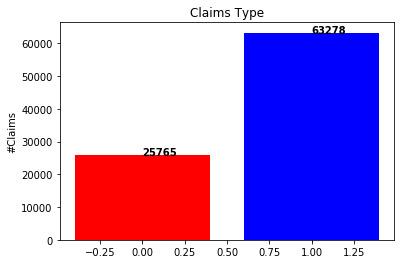

In [173]:
objects = ('Declined', 'Paid')
y_pos = np.arange(len(objects))
x_claims = list(csClaim.values())
fig, ax = plt.subplots()

ax.bar(y_pos, x_claims, align='center', color=['red', 'blue'])

tsum = sum(x_claims)
tp = tsum/tsum
for i, (v, p) in enumerate(zip(x_claims, pclaim)):
    ax.text(i, v-5, str(v), color='black', fontweight='bold')

ax.set_xticks(y_pos, objects)
plt.ylabel('#Claims')
plt.title('Claims Type')

plt.show()

In [86]:
Claims_Status.reset_index(inplace=True)
print(Claims_Status.shape, Claims_Status.head(10))

(89043, 83)    PRIMARY_CUSTOMER_GK  DIM_CLAIM_TYPE_PK  DIM_CLAIM_STATUS_PK  \
0               252233                  1                   22   
1               252029                 38                   22   
2               404730                 21                   37   
3               313024                 38                   22   
4               252233                 21                   22   
5               270825                 21                   37   
6               270825                 21                   37   
7               294734                 21                   37   
8               279920                 21                   37   
9               283685                 21                   37   

   DIM_CLAIM_REASON_PK  FACT_CUSTOMER_CLAIMS_PK TRX_CUSTOMER_CLAIMS_ID  \
0                   70                 12583533            R-7089121-1   
1                  371                 12290438            R-6973589-2   
2                   73                 

In [91]:
Claims_AMT = Claims_Status[Claims_Status['TOTAL_CLAIMS_DOLLAR_AMT']>0]
print(Claims_AMT.shape)

(84584, 83)


In [126]:
Claims_Class = pd.DataFrame({'numClaims': Claims_AMT.groupby( [ "PRIMARY_CUSTOMER_GK", "CLAIM_STATUS_TYPE_CD"] ).size()}).reset_index()
print(Claims_Class.shape, Claims_Class.head(20))

(10324, 3)     PRIMARY_CUSTOMER_GK  CLAIM_STATUS_TYPE_CD  numClaims
0                 55116                     1          1
1                 55121                     1          2
2                 55213                     1         12
3                 55310                     0          1
4                 55490                     1          7
5                 55602                     1          1
6                 55642                     1          3
7                 55769                     0          4
8                 56229                     0          5
9                 56229                     1          1
10                58684                     1          6
11                58695                     1          7
12                58696                     1          4
13                58700                     1          3
14                58726                     1          5
15                58730                     1          4
16                58

In [128]:
Claims_Dollar = pd.DataFrame({'dollarClaims': Claims_AMT.groupby(["PRIMARY_CUSTOMER_GK", "CLAIM_STATUS_TYPE_CD"])['TOTAL_CLAIMS_DOLLAR_AMT'].sum()}).reset_index()
Claims_Dollar = Claims_Dollar.drop("CLAIM_STATUS_TYPE_CD", axis=1)
print(Claims_Dollar.shape, Claims_Dollar.head(20))

(10324, 2)     PRIMARY_CUSTOMER_GK  dollarClaims
0                 55116         46.00
1                 55121       4675.67
2                 55213      13445.83
3                 55310       2278.70
4                 55490      11372.89
5                 55602        815.52
6                 55642       1217.15
7                 55769       5619.85
8                 56229       6947.98
9                 56229       1977.57
10                58684      25772.64
11                58695       7499.55
12                58696       1164.10
13                58700        203.39
14                58726       3510.15
15                58730        577.52
16                58774       3792.23
17                58797        751.00
18                58797        243.37
19                58851      33444.99


In [129]:
Claims_Dollar = Claims_Dollar.set_index('PRIMARY_CUSTOMER_GK')
Claims_Class = Claims_Class.set_index('PRIMARY_CUSTOMER_GK')
Claims_Con = pd.concat([Claims_Class, Claims_Dollar], axis=1)
print(Claims_Con.head(2), Claims_Con.shape)

                     CLAIM_STATUS_TYPE_CD  numClaims  dollarClaims
PRIMARY_CUSTOMER_GK                                               
55116                                   1          1         46.00
55121                                   1          2       4675.67 (10324, 3)


In [130]:
customer_unique = set(customerSale.index)
uniqueCnt = len(customer_unique)
print(uniqueCnt) 

35271


In [131]:
claims_unique = set(Claims_Con.index)
uniqueCnt = len(claims_unique)
print(uniqueCnt) 

7698


# Combine Claims and Sales data

In [137]:
#Claims_Customer = Claims_Type.join(ClaimCustomer, rsuffix = '_customer')
Claims_Customer = pd.concat([Claims_Con, customerSale, customerName], axis=1, join_axes = [Claims_Con.index])
Claims_Customer = Claims_Customer.rename(columns={"CLAIM_STATUS_TYPE_CD": "Claims"})
print(Claims_Customer.shape, Claims_Customer.head(5))

(10324, 13)                      Claims  numClaims  dollarClaims  numSales  dollarSales  \
PRIMARY_CUSTOMER_GK                                                           
55116                     1          1         46.00      10.0    241296.53   
55121                     1          2       4675.67      10.0    112419.43   
55213                     1         12      13445.83       8.0     42637.88   
55310                     0          1       2278.70      11.0    633067.71   
55490                     1          7      11372.89       3.0    -10863.68   

                                      CUSTOMER_NAME      index  FISCAL_YR_NUM  \
PRIMARY_CUSTOMER_GK                                                             
55116                               CB FLOORING LLC   990654.0        20170.0   
55121                               CB FLOORING LLC   970688.0        20170.0   
55213                COMMERCIAL CPTS OF AMERICA INC   685727.0        16136.0   
55310                      FA

In [138]:
tagList = list(Claims_Customer.head(1).columns.values)
print(tagList, len(tagList))

['Claims', 'numClaims', 'dollarClaims', 'numSales', 'dollarSales', 'CUSTOMER_NAME', 'index', 'FISCAL_YR_NUM', 'FISCAL_MONTH_NUM', 'SOLD_TO_CUSTOMER_PK', 'CUSTOMER_NUM', 'CUSTOMER_SUFFIX_NUM', 'SLS'] 13


In [139]:
tagList1 = [x for x in tagList if "_reason" not in x]
tagList2 = [x for x in tagList1 if "_status" not in x]
tagList3 = [x for x in tagList2 if "_type" not in x]
tagList = [x for x in tagList3 if "_customer" not in x]
print(tagList, len(tagList))

['Claims', 'numClaims', 'dollarClaims', 'numSales', 'dollarSales', 'CUSTOMER_NAME', 'index', 'FISCAL_YR_NUM', 'FISCAL_MONTH_NUM', 'SOLD_TO_CUSTOMER_PK', 'CUSTOMER_NUM', 'CUSTOMER_SUFFIX_NUM', 'SLS'] 13


In [140]:
# save data into csv file
ClaimData = Claims_Customer[tagList]
ClaimData.to_csv(frawData)
print(ClaimData.shape)

(10324, 13)


# Claim Data Processing
Building the recommendation/scoring model from Customer angle. Factors used in the modeling:
- Customer Name
- SLS = Sales
- TOTAL_CLAIMS_DOLLAR_AMT = $Claims

Derivated variables:
 - Total claims each customer in past year = #claim
 - Dollars each claim each customer = $/claim
 
 - Total sales each customer = SLS
 - Dollars per sale each customer = $/sale
 - Claim to sale ratio = claim/SLS

In [14]:
# read consildated claim data
ClaimData = pd.read_csv(frawData, encoding='latin1') # Read the data
print(ClaimData.columns)

Index(['PRIMARY_CUSTOMER_GK', 'Claims', 'numClaims', 'dollarClaims',
       'numSales', 'dollarSales', 'CUSTOMER_NAME', 'index', 'FISCAL_YR_NUM',
       'FISCAL_MONTH_NUM', 'SOLD_TO_CUSTOMER_PK', 'CUSTOMER_NUM',
       'CUSTOMER_SUFFIX_NUM', 'SLS'],
      dtype='object')


In [15]:
remove_list = ['index', 'FISCAL_YR_NUM',
       'FISCAL_MONTH_NUM', 'SOLD_TO_CUSTOMER_PK', 'CUSTOMER_NUM',
       'CUSTOMER_SUFFIX_NUM', 'SLS']
for item in remove_list:
    ClaimData = ClaimData.drop(item, axis=1)
    
print(ClaimData.shape, ClaimData.head(2))

(10324, 7)    PRIMARY_CUSTOMER_GK  Claims  numClaims  dollarClaims  numSales  \
0                55116       1          1         46.00      10.0   
1                55121       1          2       4675.67      10.0   

   dollarSales    CUSTOMER_NAME  
0    241296.53  CB FLOORING LLC  
1    112419.43  CB FLOORING LLC  


(10019, 7)


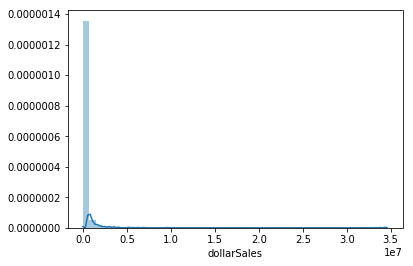

In [16]:
# filter data to have SLS > 10
customerData_SLS = ClaimData[ClaimData["dollarSales"]>100]
sns.distplot(customerData_SLS["dollarSales"])
print(customerData_SLS.shape)

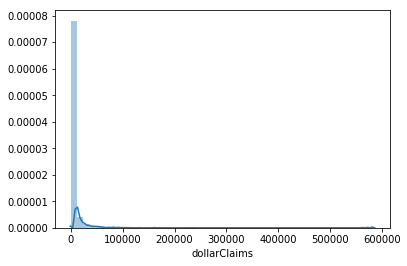

In [17]:
sns.distplot(customerData_SLS["dollarClaims"])

(10019, 7)


C:\anaconda35\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


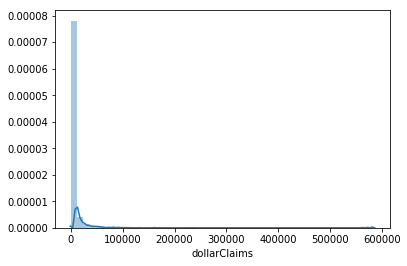

In [18]:
# filter data to have TOTAL_CLAIMS_DOLLAR_AMT > 1
customerData_AMT = customerData_SLS[ClaimData['dollarClaims']>0]
sns.distplot(customerData_AMT['dollarClaims'])
print(customerData_AMT.shape)

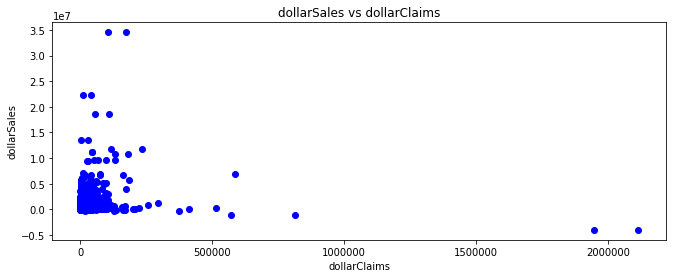

In [19]:
def _plot_scatter(data, xTag, yTag):
    # Set style of scatterplot
    #sns.set_context("notebook", font_scale=1.1)
    #sns.set_style("ticks")
    from itertools import cycle
    color_gen = cycle(('blue', 'lightgreen', 'red', 'purple', 'gray', 'cyan'))

    # Create scatterplot of dataframe
    fig = plt.figure(figsize=(11,4)) 
    plt.scatter(data[xTag], # Horizontal axis
               data[yTag], # Vertical axis
               c = next(color_gen))

    # Set title
    plt.title(yTag + ' vs ' + xTag)

    # Set x-axis label
    plt.xlabel(xTag)

    # Set y-axis label
    plt.ylabel(yTag)
    plt.show()

xTag = 'dollarClaims'
yTag = 'dollarSales'
_plot_scatter(ClaimData, xTag, yTag)

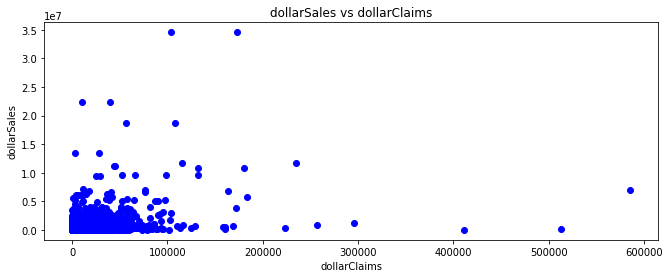

In [20]:
_plot_scatter(customerData_SLS, xTag, yTag)

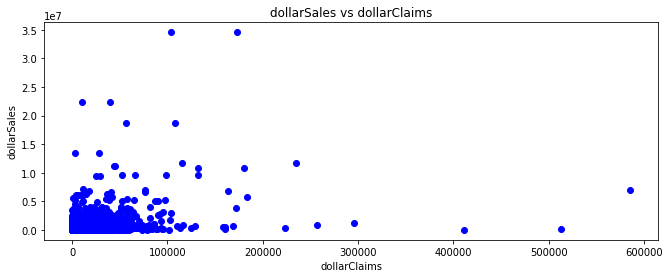

In [21]:
_plot_scatter(customerData_AMT, xTag, yTag)

In [22]:
index_nan = ClaimData['dollarClaims'].index[ClaimData['dollarClaims']<100]
print(index_nan.shape)

(424,)


In [23]:
index_nan2 = customerData_SLS['dollarClaims'].index[customerData_SLS['dollarClaims']<0]
print(index_nan2.shape)

(0,)


In [24]:
customerData = customerData_AMT.groupby(['CUSTOMER_NAME', 'dollarClaims']).sum()
print(customerData.shape)

(10003, 5)


In [25]:
ClaimData = customerData_AMT
#create a pivot table to reshape the data, using sum or count function
claimDollar = ClaimData.pivot_table(index='CUSTOMER_NAME', values='dollarClaims', aggfunc=sum)
print(claimDollar.head(2), claimDollar.shape)

                  dollarClaims
CUSTOMER_NAME                 
067 / STERLING          609.68
1089322 B.C. LTD        955.37 (6929, 1)


In [26]:
claimDollar_na = claimDollar.dropna(axis=0, how = 'any')
print(claimDollar_na.shape)

(6929, 1)


In [154]:
#create a pivot table to reshape the data, using sum or count function
"""
saleNumber = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=len)
saleNumber = saleNumber.rename(columns = {'SLS':'NumberSales'})
saleDollar = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=sum)
print(saleDollar.head(2), saleDollar.shape)
"""

"\nsaleNumber = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=len)\nsaleNumber = saleNumber.rename(columns = {'SLS':'NumberSales'})\nsaleDollar = ClaimData.pivot_table(index='CUSTOMER_NAME', values='SLS', aggfunc=sum)\nprint(saleDollar.head(2), saleDollar.shape)\n"

In [155]:
#saleDollar_na = saleDollar.dropna(axis = 0, how = 'any')
#print(saleDollar_na.shape)

In [156]:
#saleData = pd.concat([saleDollar_na, saleNumber], axis=1, join_axes=[saleDollar_na.index])
#saleData['DollarPerSale'] = saleData['SLS']/saleData['NumberSales']
#print(saleData.shape, saleData.head(2))

In [157]:
#customerData = pd.concat([saleData, claimDollar_na], axis=1, join_axes=[saleData.index])
#customerData['ClaimRatio'] = customerData['TOTAL_CLAIMS_DOLLAR_AMT']/customerData['SLS']
#print(customerData.shape, customerData.head(2))

In [158]:
#create a pivot table to reshape the data, using sum or count function
#claimCnt = ClaimData.pivot_table(index='CUSTOMER_NAME', values='TOTAL_CLAIMS_DOLLAR_AMT', aggfunc=len)
#claimCnt = claimCnt.rename(columns = {'TOTAL_CLAIMS_DOLLAR_AMT':'Total_Claims'})
#print(claimCnt.head(2), claimCnt.shape)

In [27]:
# join count claim
#modelData = pd.concat([customerData, claimCnt], axis=1, join_axes=[customerData.index])
modelData = ClaimData
modelData['dollarPerClaim'] = modelData['dollarClaims']/modelData['numClaims']
modelData['dollarPerSale'] = modelData['dollarSales']/modelData['numSales']
modelData['claimRatio'] = modelData['dollarClaims']/modelData['dollarSales']
print(modelData.shape, modelData.head(2))

(10019, 10)    PRIMARY_CUSTOMER_GK  Claims  numClaims  dollarClaims  numSales  \
0                55116       1          1         46.00      10.0   
1                55121       1          2       4675.67      10.0   

   dollarSales    CUSTOMER_NAME  dollarPerClaim  dollarPerSale  claimRatio  
0    241296.53  CB FLOORING LLC          46.000      24129.653    0.000191  
1    112419.43  CB FLOORING LLC        2337.835      11241.943    0.041591  


In [28]:
modelData.reset_index(inplace=True)
print(modelData.head(20), modelData.shape)

    index  PRIMARY_CUSTOMER_GK  Claims  numClaims  dollarClaims  numSales  \
0       0                55116       1          1         46.00      10.0   
1       1                55121       1          2       4675.67      10.0   
2       2                55213       1         12      13445.83       8.0   
3       3                55310       0          1       2278.70      11.0   
4       5                55602       1          1        815.52      10.0   
5       6                55642       1          3       1217.15       4.0   
6       7                55769       0          4       5619.85       6.0   
7      10                58684       1          6      25772.64       6.0   
8      11                58695       1          7       7499.55       4.0   
9      12                58696       1          4       1164.10      11.0   
10     13                58700       1          3        203.39      12.0   
11     15                58730       1          4        577.52      10.0   

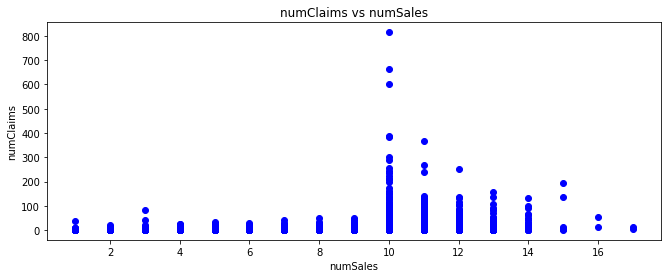

In [29]:
xTag = 'numSales'
yTag = 'numClaims'
_plot_scatter(modelData, xTag, yTag)

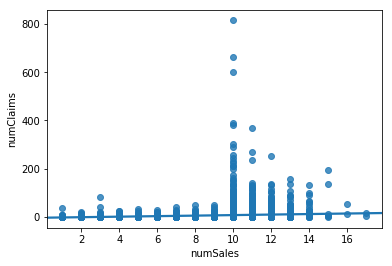

In [30]:
 ax = sns.regplot(x=xTag, y=yTag, data=modelData)

# Visualization of modeling data

In [31]:
print(modelData.shape, modelData.head(2))

(10019, 11)    index  PRIMARY_CUSTOMER_GK  Claims  numClaims  dollarClaims  numSales  \
0      0                55116       1          1         46.00      10.0   
1      1                55121       1          2       4675.67      10.0   

   dollarSales    CUSTOMER_NAME  dollarPerClaim  dollarPerSale  claimRatio  
0    241296.53  CB FLOORING LLC          46.000      24129.653    0.000191  
1    112419.43  CB FLOORING LLC        2337.835      11241.943    0.041591  


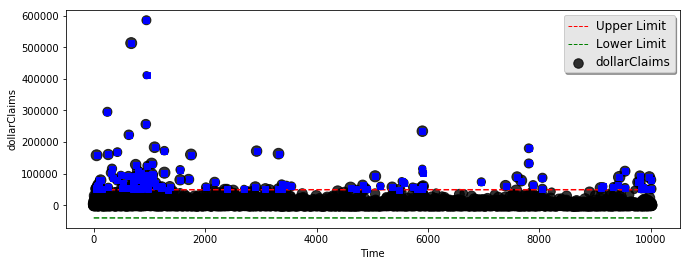

Number of above upper limit points =  131.0
Above upperlimit points: [40, 44, 52, 67, 81, 94, 99, 100, 124, 152, 245, 260, 262, 302, 328, 353, 425, 426, 488, 509, 533, 583, 623, 630, 654, 673, 698, 709, 711, 723, 730, 737, 742, 753, 771, 786, 814, 824, 837, 841, 851, 856, 860, 883, 892, 917, 935, 944, 945, 946, 948, 963, 964, 973, 974, 1039, 1040, 1066, 1072, 1093, 1101, 1118, 1201, 1209, 1220, 1268, 1269, 1335, 1366, 1551, 1552, 1703, 1747, 2014, 2171, 2391, 2699, 2901, 2924, 3082, 3316, 3318, 3374, 3375, 3457, 3547, 4611, 4714, 4828, 4874, 4906, 5052, 5147, 5357, 5488, 5531, 5571, 5728, 5797, 5894, 5897, 5899, 5900, 5906, 5908, 5912, 6959, 7393, 7600, 7674, 7810, 7811, 7888, 8055, 8056, 9100, 9148, 9328, 9405, 9434, 9538, 9539, 9769, 9803, 9804, 9834, 9863, 9928, 9974, 10008, 10011]


In [32]:
#sns.lmplot(x="SLS", y="ClaimRatio", data=modelData, hue="ClaimRatio", fit_reg=False, size = 8);
#series plot over three sigma

yName = "dollarClaims"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

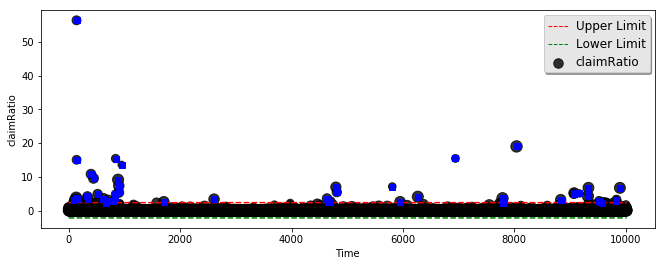

Number of above upper limit points =  48.0
Above upperlimit points: [97, 134, 140, 141, 142, 336, 338, 400, 445, 519, 624, 673, 708, 792, 826, 838, 841, 886, 899, 900, 948, 1707, 2609, 4637, 4661, 4695, 4796, 4813, 5809, 5949, 6267, 6943, 7788, 7789, 8040, 8833, 9069, 9074, 9170, 9321, 9330, 9331, 9520, 9536, 9582, 9832, 9834, 9896]


In [33]:
yName = "claimRatio"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

In [34]:
# ClaimAMT = 0
CR0 = modelData[modelData["claimRatio"]==0]
print(CR0.shape)

(0, 11)


In [35]:
LargeCR = modelData[modelData["claimRatio"] > 1]
print(LargeCR.shape)

(142, 11)


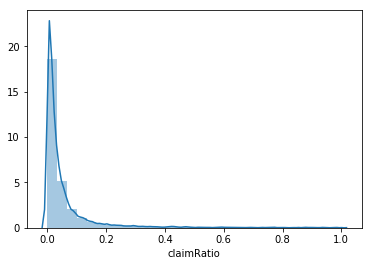

In [36]:
modelData_tmp = modelData[modelData['claimRatio'] < 1]
data = modelData_tmp['claimRatio']
sns.distplot(data, bins=30)
plt.show()

In [37]:
LargeDPS= modelData[modelData["dollarPerSale"] > 1000]
print(LargeDPS.shape)

(9586, 11)


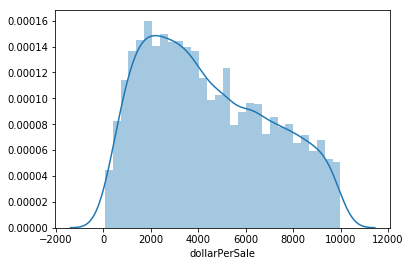

In [38]:
tag = 'dollarPerSale'
modelData_tmp = modelData[modelData[tag] < 10000]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

(2152, 11)


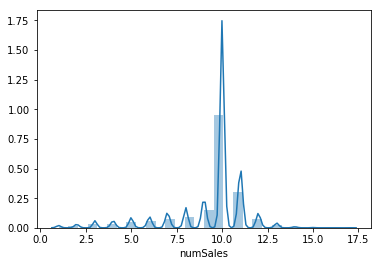

In [39]:
tag = 'numSales'
LargeS= modelData[modelData[tag] > 10]
print(LargeS.shape)

modelData_tmp = modelData[modelData[tag] < 40]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

In [40]:
LargeDPC= modelData[modelData["dollarPerClaim"] > 1000]
print(LargeDPC.shape)

(2105, 11)


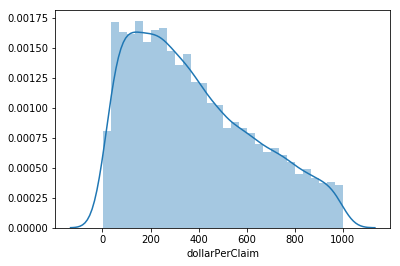

In [41]:
tag = 'dollarPerClaim'
modelData_tmp = modelData[modelData[tag] < 1000]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

(10006, 11)


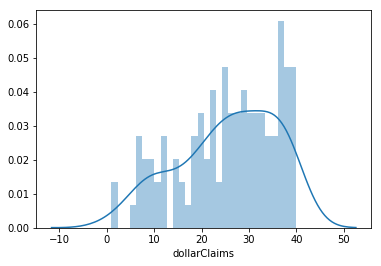

In [42]:
tag = 'dollarClaims'
LargeC= modelData[modelData[tag] > 10]
print(LargeC.shape)

modelData_tmp = modelData[modelData[tag] < 40]
data = modelData_tmp[tag]
sns.distplot(data, bins=30)
plt.show()

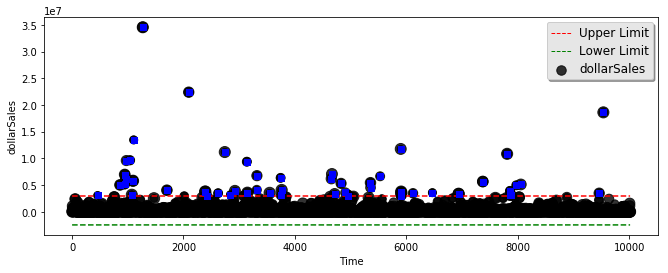

Number of above upper limit points =  103.0
Above upperlimit points: [458, 459, 860, 861, 943, 944, 945, 946, 967, 968, 973, 974, 1039, 1040, 1071, 1072, 1092, 1093, 1105, 1106, 1268, 1269, 1702, 1703, 2094, 2095, 2390, 2391, 2413, 2414, 2621, 2622, 2741, 2742, 2839, 2840, 2923, 2924, 3137, 3138, 3148, 3149, 3315, 3316, 3317, 3318, 3546, 3547, 3743, 3744, 3752, 3753, 3761, 3762, 4654, 4655, 4665, 4714, 4715, 4828, 4829, 4906, 4945, 4946, 5356, 5357, 5358, 5530, 5531, 5899, 5900, 5905, 5906, 5907, 5908, 5909, 5910, 5911, 5912, 6120, 6121, 6468, 6469, 6939, 6940, 7373, 7374, 7810, 7811, 7862, 7863, 7864, 7865, 7887, 7888, 7975, 7976, 8055, 8056, 9463, 9464, 9538, 9539]


In [43]:
yName = "dollarSales"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

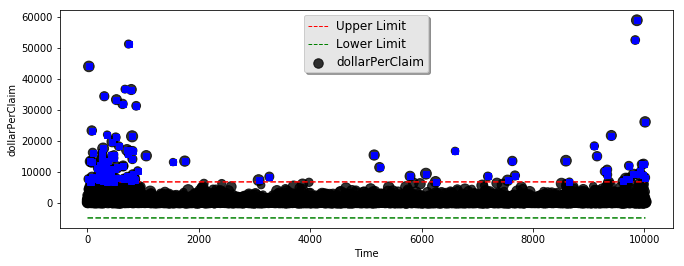

Number of above upper limit points =  113.0
Above upperlimit points: [17, 25, 44, 54, 63, 74, 76, 77, 81, 93, 179, 204, 210, 217, 226, 245, 260, 262, 265, 266, 276, 278, 281, 302, 320, 327, 328, 336, 352, 353, 364, 365, 401, 411, 418, 420, 425, 445, 462, 465, 468, 471, 475, 486, 507, 509, 520, 527, 560, 630, 640, 642, 645, 656, 673, 701, 709, 711, 730, 737, 762, 768, 780, 784, 786, 801, 807, 812, 814, 819, 824, 840, 842, 859, 874, 900, 1055, 1536, 1747, 3073, 3265, 5147, 5243, 5791, 6076, 6249, 6600, 7188, 7542, 7627, 7674, 8590, 8652, 9100, 9148, 9284, 9330, 9334, 9405, 9615, 9665, 9716, 9719, 9803, 9834, 9863, 9896, 9928, 9951, 9974, 9984, 10008, 10011]


In [44]:
yName = "dollarPerClaim"
dt = modelData.index #pd.to_datetime(modelData['CREATE_DTM'])
ifactor = 3
xd = modelData[yName]
_plot_value_series(xd, dt, ifactor,yName,1)

count    10019.000000
mean       851.077054
std       1941.380551
min          1.000000
25%        210.136667
50%        432.555556
75%        868.403929
max      58925.440000
Name: dollarPerClaim, dtype: float64


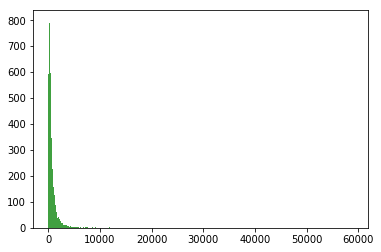

In [45]:
n, bins, patches = plt.hist(xd, bins='auto', facecolor='green', alpha=0.75)
print(xd.describe())

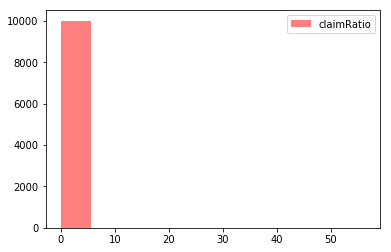

In [46]:
# box plot
plt.hist(np.array(modelData['claimRatio']), color=['r'], alpha=0.5, label='claimRatio')
plt.legend(loc='upper right')
plt.show()

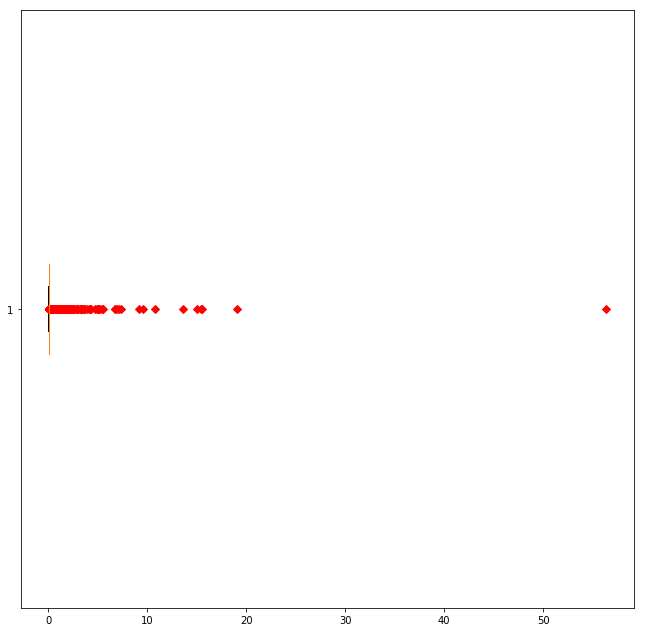

In [47]:
_plot_boxplot(np.array(modelData['claimRatio']))

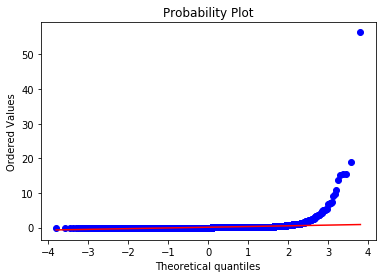

In [48]:
#series plot over three sigma
yName = "claimRatio"
ifactor = 3
xd = modelData[yName]
_plot_QQ(xd) 

In [49]:
import pandas as pd
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)
#pd.set_option('display.width', 1000)

In [50]:
# save data into csv file
modelData.to_csv(fmodelData)
print(modelData.shape, modelData.head(2))
class_info(modelData.Claims)

(10019, 11)    index  PRIMARY_CUSTOMER_GK  Claims  numClaims  dollarClaims  numSales  \
0      0                55116       1          1         46.00      10.0   
1      1                55121       1          2       4675.67      10.0   

   dollarSales    CUSTOMER_NAME  dollarPerClaim  dollarPerSale  claimRatio  
0    241296.53  CB FLOORING LLC          46.000      24129.653    0.000191  
1    112419.43  CB FLOORING LLC        2337.835      11241.943    0.041591  
     1:    6358  =   63.5%
     0:    3661  =   36.5%


In [182]:
modelData.drop(['Unnamed: 0', 'index'], inplace=True, axis = 1)
print(modelData.head(5))

   PRIMARY_CUSTOMER_GK  Claims  numClaims  dollarClaims  numSales  \
0                55116       1          1         46.00      10.0   
1                55121       1          2       4675.67      10.0   
2                55213       1         12      13445.83       8.0   
3                55310       0          1       2278.70      11.0   
4                55602       1          1        815.52      10.0   

   dollarSales                   CUSTOMER_NAME  dollarPerClaim  dollarPerSale  \
0    241296.53                 CB FLOORING LLC       46.000000      24129.653   
1    112419.43                 CB FLOORING LLC     2337.835000      11241.943   
2     42637.88  COMMERCIAL CPTS OF AMERICA INC     1120.485833       5329.735   
3    633067.71        FAMILY CARPET OUTLET INC     2278.700000      57551.610   
4   1088677.47                  NORDSTROMS INC      815.520000     108867.747   

   claimRatio  
0    0.000191  
1    0.041591  
2    0.315349  
3    0.003599  
4    0.000749  


In [183]:
modelData_gk = modelData.set_index('PRIMARY_CUSTOMER_GK')
print(modelData_gk.head(5))

                     Claims  numClaims  dollarClaims  numSales  dollarSales  \
PRIMARY_CUSTOMER_GK                                                           
55116                     1          1         46.00      10.0    241296.53   
55121                     1          2       4675.67      10.0    112419.43   
55213                     1         12      13445.83       8.0     42637.88   
55310                     0          1       2278.70      11.0    633067.71   
55602                     1          1        815.52      10.0   1088677.47   

                                      CUSTOMER_NAME  dollarPerClaim  \
PRIMARY_CUSTOMER_GK                                                   
55116                               CB FLOORING LLC       46.000000   
55121                               CB FLOORING LLC     2337.835000   
55213                COMMERCIAL CPTS OF AMERICA INC     1120.485833   
55310                      FAMILY CARPET OUTLET INC     2278.700000   
55602               

# Preprocess inputs to model Claim Scoring

Possible Inputs:
- ClaimRatio
- DollarPerClaim ($/claim)

- DollarPerSale ($/sale)
- #Sales
- #Claims

In [51]:
# read consildated model data
modelData = pd.read_csv(fmodelData, encoding='latin1') # Read the data
print(modelData.columns, modelData.head(5))

Index(['Unnamed: 0', 'index', 'PRIMARY_CUSTOMER_GK', 'Claims', 'numClaims',
       'dollarClaims', 'numSales', 'dollarSales', 'CUSTOMER_NAME',
       'dollarPerClaim', 'dollarPerSale', 'claimRatio'],
      dtype='object')    Unnamed: 0  index  PRIMARY_CUSTOMER_GK  Claims  numClaims  dollarClaims  \
0           0      0                55116       1          1         46.00   
1           1      1                55121       1          2       4675.67   
2           2      2                55213       1         12      13445.83   
3           3      3                55310       0          1       2278.70   
4           4      5                55602       1          1        815.52   

   numSales  dollarSales                   CUSTOMER_NAME  dollarPerClaim  \
0      10.0    241296.53                 CB FLOORING LLC       46.000000   
1      10.0    112419.43                 CB FLOORING LLC     2337.835000   
2       8.0     42637.88  COMMERCIAL CPTS OF AMERICA INC     1120.485833   
3    

In [52]:
# Normalize data
    # manually selected tags -- no normalized or PCA
def _read_inputTags():
    inputTags = ['numClaims',
               'numSales',
               'dollarPerClaim',
               'dollarPerSale',
               'claimRatio'
              ]
    return inputTags

inputTags = _read_inputTags()
yTags = 'Claims'

In [53]:
customerID = modelData['CUSTOMER_NAME']
X = modelData[inputTags]
y = modelData[yTags]

print(X.head(2), X.shape)

   numClaims  numSales  dollarPerClaim  dollarPerSale  claimRatio
0          1      10.0          46.000      24129.653    0.000191
1          2      10.0        2337.835      11241.943    0.041591 (10019, 5)


In [54]:
class_info(y)

     1:    6358  =   63.5%
     0:    3661  =   36.5%


In [55]:
# split data
ts = 0.3
xTrain, xTest, yTrain, yTest = train_test_split(X, y, stratify=y, test_size=ts, random_state=531)  

In [56]:
# normalize data
xvalue = xTrain.values 
normX_scaler = preprocessing.StandardScaler().fit(xvalue) 
xScaled = normX_scaler.transform(xvalue)   
xScaled_test = normX_scaler.transform(xTest.values) 
xnTrain = pd.DataFrame(xScaled)
xnTest = pd.DataFrame(xScaled_test)

In [57]:
xnTrain.index = xTrain.index
xnTrain.columns = xTrain.columns
xnTest.index = xTest.index
xnTest.columns = xTest.columns

In [58]:
class_info(yTrain)
class_info(yTest)

     0:    2563  =   36.5%
     1:    4450  =   63.5%
     0:    1098  =   36.5%
     1:    1908  =   63.5%


In [59]:
#split the training data into modeling set and validation set
nxModel, nxValid, yModel, yValid = train_test_split(xnTrain, yTrain, stratify=yTrain, test_size=ts, random_state=531)
class_info(yModel)
class_info(yValid)

     1:    3115  =   63.5%
     0:    1794  =   36.5%
     0:     769  =   36.5%
     1:    1335  =   63.5%


# Modeling using Different Methods

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets
from sklearn.utils.validation import column_or_1d
from sklearn.metrics import accuracy_score

In [78]:
# <codecell>

# let's switch to 2-dimensional curves; specifically, the ROC and precision-recall curves.
# Define two functions to plot ROC and Precision-Recall curves.

def plot_ROC_curve(classifier, X, y, pos_label=1, n_folds=5):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure()
    aucs = []
    all_tpr = []
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X.iloc[train,:], y[train]).predict_proba(X.iloc[test,:])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        all_tpr.append(mean_tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random', alpha=0.8)
    
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), 
         lw=2, alpha=0.8)
    
    std_tpr = np.std(all_tpr, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color = 'grey', alpha=0.2,
                     label = r'$\pm$ 1 std. dev.')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return classifier
  

In [62]:
xm = nxModel.iloc[:, 3:5]
#xm = pd.DataFrame(xm)
print(xm.head(2))
n_features = X.shape[1]

C = 1.0
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

      dollarPerSale  claimRatio
707       -0.031957   -0.182864
2835      -0.208136   -0.153524


             3         4
1116 -0.031957 -0.182864
3024 -0.208136 -0.153524


In [67]:
# Create different classifiers. The logistic regression cannot do
# multiclass out of the box.
classifiers = {'L1 logistic': LogisticRegression(C=C, penalty='l1'),
               'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2'),
               'RBF SVC': SVC(kernel='rbf', C=C, class_weight='balanced',probability=True,
                                 random_state=0),
               'Linear SVC': SVC(kernel='linear', C=C, class_weight='balanced',probability=True,
                                 random_state=0),
               'L2 logistic (Multinomial)': LogisticRegression(
                C=C, solver='lbfgs', multi_class='multinomial')
               #'GPC': GaussianProcessClassifier(kernel)
               }

n_classifiers = len(classifiers)

classif_rate for L1 logistic : 63.454879 
classif_rate for L2 logistic (OvR) : 63.475250 
classif_rate for RBF SVC : 61.927073 
classif_rate for Linear SVC : 63.169688 
classif_rate for L2 logistic (Multinomial) : 63.475250 


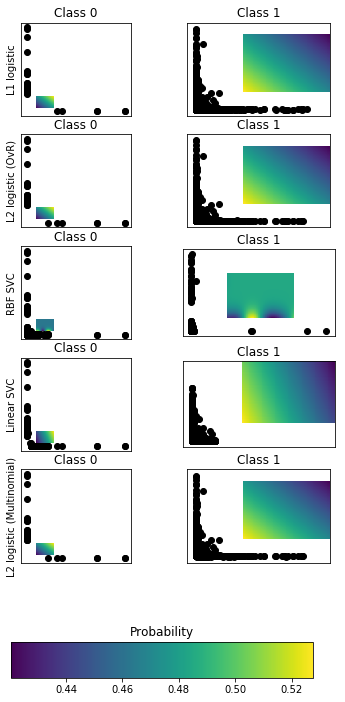

In [68]:
plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(xm, yModel)

    y_pred = classifier.predict(xm)
    classif_rate = np.mean(y_pred.ravel() == yModel.ravel()) * 100
    print("classif_rate for %s : %f " % (name, classif_rate))

    # View probabilities=
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(3, 9, 1, 5), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(xm.iloc[idx,0], xm.iloc[idx,1], marker='o', c='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

In [84]:
def _verify_claim(classifier, xValid, yValid):
    
    y_pred = classifier.predict(xValid)
    classif_rate = np.mean(y_pred.ravel() == yValid.ravel()) * 100
    print("classif_rate for %s : %f \n" % (name, classif_rate))

    # Output probabilities
    valFull = np.c_[xValid, yValid]
    probas = classifier.predict_proba(xValid)
    
    test_results = [Declined', 'Paid']   
    print ("\nModel Report")
    print(classification_report(yValid, y_pred, target_names= test_results))
    print("Predicted Declined Claims = %s" %sum(column_or_1d(y_pred)))
    print ("Accuracy : %.4g" % accuracy_score(yValid.values, y_pred))
    
    # output results
    proba = pd.DataFrame(data=probas[:,0], index = yValid.index, columns = ['Score'])
    yPred = pd.DataFrame(data=y_pred, index = yValid.index, columns = ['Pred'])
    res_pred = pd.concat([yValid, yPred, proba], axis=1)
    return res_pred    

In [85]:
for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(nxModel, yModel)
    res_pred = _verify_claim(classifier, nxValid, yValid)

classif_rate for L1 logistic : 68.678707 


Model Report
             precision    recall  f1-score   support

       Paid       0.69      0.26      0.38       769
   Declined       0.69      0.93      0.79      1335

avg / total       0.69      0.69      0.64      2104

Predicted Declined Claims = 1818
Accuracy : 0.6868
classif_rate for L2 logistic (OvR) : 68.821293 


Model Report
             precision    recall  f1-score   support

       Paid       0.70      0.26      0.38       769
   Declined       0.69      0.94      0.79      1335

avg / total       0.69      0.69      0.64      2104

Predicted Declined Claims = 1819
Accuracy : 0.6882
classif_rate for RBF SVC : 71.435361 


Model Report
             precision    recall  f1-score   support

       Paid       0.61      0.60      0.60       769
   Declined       0.77      0.78      0.78      1335

avg / total       0.71      0.71      0.71      2104

Predicted Declined Claims = 1356
Accuracy : 0.7144
classif_rate for Linear SVC :

In [184]:
print(res_pred.head(20), res_pred.shape)

      Claims  Pred     Score
6580       0     0  0.576681
840        0     0  0.836356
6219       0     1  0.482733
3155       1     1  0.003144
9585       1     0  0.634878
6991       1     1  0.419064
3457       1     1  0.011617
228        1     1  0.476286
3755       1     1  0.404435
5043       1     1  0.395252
4407       1     1  0.298046
979        1     1  0.415023
8040       0     0  0.549292
5394       1     1  0.425130
6844       1     1  0.361341
1678       1     1  0.436160
395        0     0  0.631535
5757       0     0  0.701919
3644       0     1  0.407578
4458       1     1  0.371009 (2104, 3)


# Plot claim scoring data

In [230]:
# read consildated claim data
fscoreData = 'C:/Users/E154709/Desktop/Mohawk/Claims/eclf_output.csv'
claimScore = pd.read_csv(fscoreData, encoding='latin1') # Read the data
print(claimScore.head(5), claimScore.shape)

   Item  Customer_GK  numClaims  numSales  dollarPerClaim  dollarPerSale  \
0     1         9911  -0.209033 -3.928868        0.919042      -0.119748   
1     2          865  -0.302308 -3.928868        0.950694      -0.185358   
2     3         7079  -0.302308 -3.458839        0.397372      -0.246493   
3     4         7207  -0.209033 -3.928868        0.036118      -0.223279   
4     5          748  -0.302308 -3.458839        0.793447      -0.235132   

   claimRatio  Claims  Pred     Score Index  
0    1.084738       0     0  0.108166   tst  
1    0.631634       0     0  0.115440   val  
2    1.234730       0     0  0.144704   tst  
3    1.475528       0     0  0.146570   tst  
4    0.927546       0     0  0.152926   val   (5110, 11)


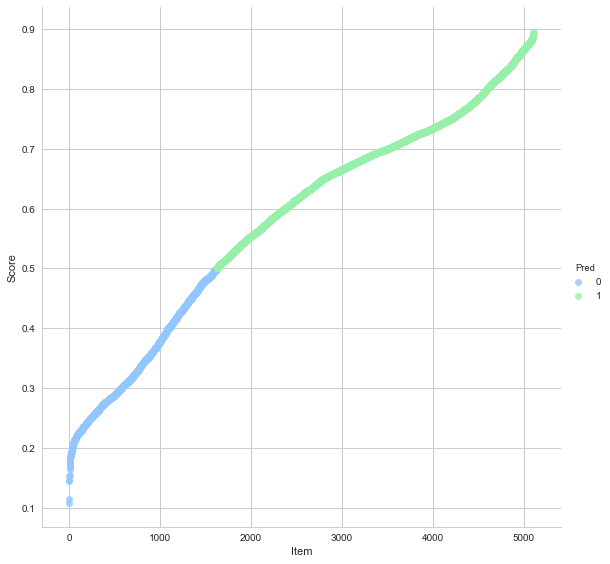

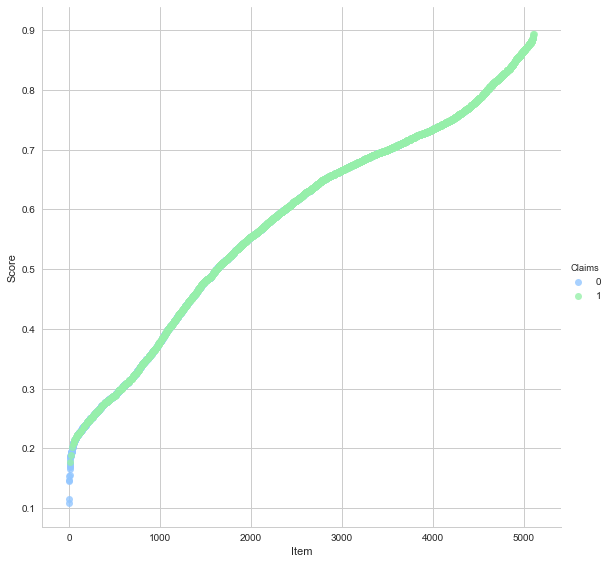

In [231]:
claimScore = claimScore.rename(columns={"Unnamed: 0": "Customer_GK", "Index": "Type"})
sortScore = claimScore.sort_values(by='Score')
sortScore.reset_index(inplace = True)
sns.lmplot(x="Item", y="Score", data=sortScore, hue="Pred", fit_reg=False, size = 8);
sns.lmplot(x="Item", y="Score", data=sortScore, hue="Claims", fit_reg=False, size = 8);

In [232]:
#sortScore = sortScore.drop('level_0', axis = 1)
print(sortScore.head(5), sortScore.shape)

   index  Item  Customer_GK  numClaims  numSales  dollarPerClaim  \
0      0     1         9911  -0.209033 -3.928868        0.919042   
1      1     2          865  -0.302308 -3.928868        0.950694   
2      2     3         7079  -0.302308 -3.458839        0.397372   
3      3     4         7207  -0.209033 -3.928868        0.036118   
4      4     5          748  -0.302308 -3.458839        0.793447   

   dollarPerSale  claimRatio  Claims  Pred     Score Type  
0      -0.119748    1.084738       0     0  0.108166  tst  
1      -0.185358    0.631634       0     0  0.115440  val  
2      -0.246493    1.234730       0     0  0.144704  tst  
3      -0.223279    1.475528       0     0  0.146570  tst  
4      -0.235132    0.927546       0     0  0.152926  val   (5110, 12)


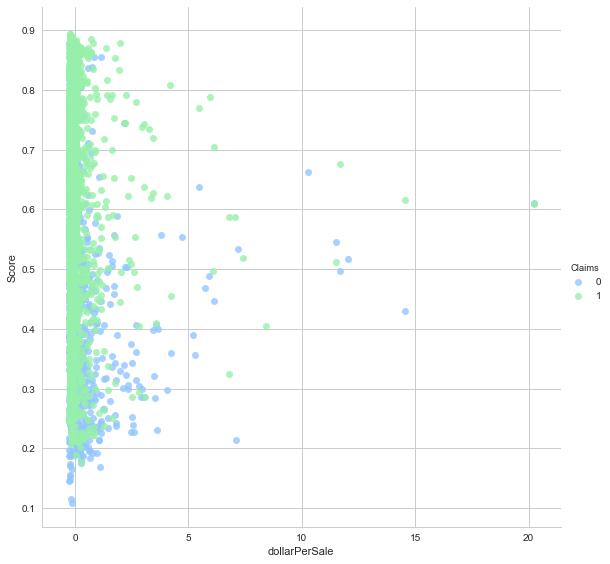

In [238]:
sns.lmplot(x = "dollarPerSale", y="Score", data=sortScore, hue="Claims", fit_reg=False, size = 8);

In [237]:
sns.set(style="whitegrid", palette="pastel", color_codes=False)

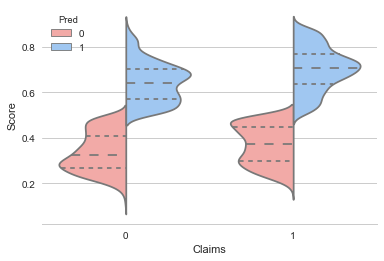

In [235]:
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="Claims", y="Score", data=sortScore, hue="Pred", split=True,
               inner="quart", palette={1: 'b', 0: 'r'})
sns.despine(left=True)

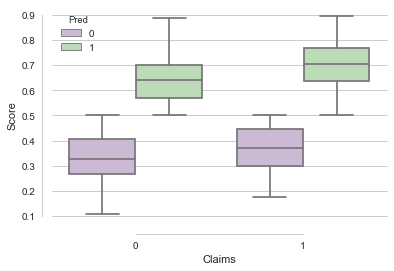

In [236]:
# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="Claims", y="Score", data=sortScore, hue="Pred", palette="PRGn")
sns.despine(offset=10, trim=True)